## Merging data from different sources for ROAD STRUCTURE
---

This notebook cleans these datasets:
* `cam_viario_pylgons: https://datos.madrid.es/sites/v/index.jsp?vgnextoid=f1555cde99be2410VgnVCM1000000b205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD
* cam_viario_axis: http://centrodedescargas.cnig.es/CentroDescargas/buscar.do?filtro.codFamilia=REDTR for Madrid
* cam_admin_districts : download https://www.madrid.org/nomecalles/DescargaBDTCorte.icm where the districts of madrid can be downloaded

And then, merges them into one with the following columns to be used for point generation:


In [111]:
import json
import geopandas as gpd
import pandas as pd
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint

In [2]:
%matplotlib inline

In [3]:
!cd ..
!pwd


/home/laura/Documents/git/wip_bicis/notebooks


----
### [1] cam_viario_polygons

* Dataset: [source](!)
* **EPSG:25830** changed to WGS 84 (Universal Proj for WebMapping)
* **Qué es**: 
>*Es un conjunto de datos con polígonos que representan el viario. Contiene:*
> * Nombre de la calle
> * Estructura de grafos (id del objecto e ids de los objetos a los que está unidos)
> * Geometría y datos de ésta en metros: area y longitud



In [4]:
# open file
viario_plgns = gpd.read_file('../base_data/cam_viario_pylgons.gpkg')
assert viario_plgns.crs.name == 'WGS 84'

viario_plgns.head(2)

,TOP_ID,TOP_ID_COM,TOP_ID_TER,TVIA_ID,TOP_DT_FCH,TOP_DT_F_1,CV_TX_DENO,DEN_TX_PAR,DEN_TX_NOM,Shape_STAr,Shape_STLe,avg_width,geometry
0,127,313425,313500,V,1983-08-01,None,Calle,de,Isabel Colbrand,28636.725342,2968.276938,NaN,"MULTIPOLYGON (((-3.67131 40.51562, -3.67131 40..."
1,150,173900,789500,V,1985-12-27,None,Calle,de,González Dávila,20679.704590,1266.932734,NaN,"MULTIPOLYGON (((-3.63951 40.37817, -3.63950 40..."


'cam_viario_polygons`:

* There are `nans`
* We have the `length` and the `area` so we could have the `avg_width`
* `TOP_ID`, `TOP_ID_COM`, `TOP_ID_TER`: Graph relationships


In [5]:
# pythonyse column names
pythonise_strings = lambda s: s.replace(' ', '_').lower()
viario_plgns.columns = list(map(pythonise_strings, viario_plgns.columns))

# drop columns that have more tan 75% nans
nan_threshold = int(np.ceil(viario_plgns.shape[0] *0.75))
viario_plgns.dropna(axis='columns', thresh=nan_threshold, inplace=True)

viario_plgns.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 9209 entries, 0 to 9208
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   top_id      9209 non-null   int64   
 1   top_id_com  9209 non-null   int64   
 2   top_id_ter  9209 non-null   int64   
 3   tvia_id     9163 non-null   object  
 4   top_dt_fch  9209 non-null   object  
 5   cv_tx_deno  9209 non-null   object  
 6   den_tx_par  8932 non-null   object  
 7   den_tx_nom  9209 non-null   object  
 8   shape_star  9209 non-null   float64 
 9   shape_stle  9209 non-null   float64 
 10  geometry    9209 non-null   geometry
dtypes: float64(2), geometry(1), int64(3), object(5)
memory usage: 791.5+ KB


In [6]:
from ast import literal_eval

rename_cols = {
    'top_id':       "('id', 'source')",
    'top_id_com':   "('id', 'start')",
    'top_id_ter':   "('id', 'end')",
    'tvia_id':      "('via', 'type')",
    "top_dt_fch":   "('via', 'date')",
    "cv_tx_deno":   "('via', 'deno')",
    "den_tx_par":   "('via', 'par')",
    "den_tx_nom":   "('via', 'name')",
    "shape_star":   "('shp', 'area')",
    "shape_stle":   "('shp', 'length')"   
}   
viario_plgns.rename_geometry(col = "('shp', 'geometry')", inplace=True)
viario_plgns.rename(columns=rename_cols, inplace=True)

viario_plgns.columns = pd.MultiIndex.from_tuples(list(map(literal_eval, viario_plgns.columns)), names=['class', 'name'])
viario_plgns.set_geometry(col = viario_plgns.columns[-1], inplace=True)

In [7]:
viario_plgns[('shp', 'avg_width')] = np.round(viario_plgns[('shp', 'area')] / viario_plgns[('shp', 'length')], 2)
viario_plgns[('shp', 'log_width')] = np.log(viario_plgns[('shp', 'avg_width')]) # avg_width tiene una distribución logaritmica

In [8]:
viario_plgns.loc[:, 'shp'].head(1)

name,area,length,geometry,avg_width,log_width
0,28636.725342,2968.276938,"MULTIPOLYGON (((-3.67131 40.51562, -3.67131 40...",9.65,2.266958


<AxesSubplot:>

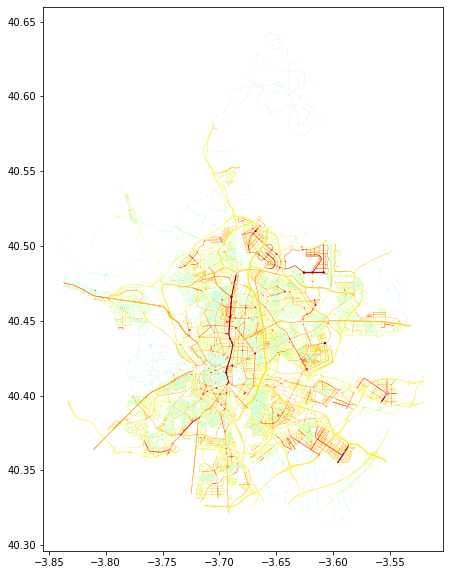

In [9]:
viario_plgns.plot(column=('shp', 'log_width'), figsize=(10,10), cmap='jet')

----
### [2] cam_viario_axis

* Dataset: [source](!)
* **EPSG:25830** changed to WGS 84 (Universal Proj for WebMapping)
* **Qué es**: 
>*Es un conjunto de datos con ejes de vías. Contiene:*
> * varios IDs y codificaciones: tramo, vial. codigos, via catastral, calse de via etc
> * quien es el titular de la via y fuente del dato
> * Pegado de a qué distrito pertenece

In [10]:
# open file
vario_axis = gpd.read_file('../base_data/cam_viario_axis.gpkg')
assert vario_axis.crs.name == 'WGS 84'

vario_axis.head(2)

,id_tramo,id_vial,codigo,codigoD,dgc_via,dgc_viaD,tipo_vial,tipo_vialD,clase,claseD,...,titular,titularD,orden,ordenD,fuente_t,fuente_tD,fecha_alta,GEOCODIGO,DESBDT,geometry
0,280790192099,600000000158,56057,None,-998,Valor no aplicable,1000,Carretera,1002,Autovía,...,5,Ayuntamiento,P,Principal,1,Instituto Geográfico Nacional,2020-07-23,07901,079 - 01 Centro,MULTILINESTRING Z ((-3.57465 40.47525 599.7150...
1,280790192096,600000000158,56057,None,-998,Valor no aplicable,1000,Carretera,1002,Autovía,...,5,Ayuntamiento,P,Principal,1,Instituto Geográfico Nacional,2020-07-23,07901,079 - 01 Centro,MULTILINESTRING Z ((-3.57453 40.46555 613.9650...


In [11]:
def drop_unique_cols(df):
    """ Drop cols that have only one value inside: No new information
    """
    for col in df.columns:

        if df[col].value_counts().index.size == 1:
            print(f"-- column to drop: {col}")
            df.drop(columns=col, inplace=True)
    return df

print(f"Number of columns: {vario_axis.columns.size}")
vario_axis = drop_unique_cols(vario_axis)
print(f"Number of columns: {vario_axis.columns.size}")

Number of columns: 42
-- column to drop: GEOCODIGO
-- column to drop: DESBDT
Number of columns: 40


* `TIPO_VIAL` y `TIPO_VIALD` van juntos: code y nombre del tipo de via:
> ['CALLE', 'AVDA', 'Carretera', 'PLAZA', 'Itinerario Europeo', 'PASEO','CTRA', 'CMNO', 'Tipo vial desconocido', 'GTA', 'Vial Camino', 'Vial bici', 'RONDA', 'TRVA', 'Red TEN-T', 'BULEV', 'PSAJE', 'CUSTA', 'CSTAN', 'COL', 'PQUE', 'CLLON', 'PNTE', 'CÑADA', 'BARDA', 'PLZLA','CRA', 'LUGAR', 'Vía verde', 'ACCES', 'BARRO', 'JDIN', 'PZO', 'PARTI','GALE']

* `clase` y `claseD` van juntos: code y nombre del tipo de via
> ['Urbano', 'Autovía', 'Carretera convencional', 'Camino', 'Autopista', 'Carril bici', 'Carretera multicarril', 'Senda']

* `fuente_v` y `fuente_vD` van juntos: code y nombre del tipo de tramo: 
> ['Troncal', 'Nudo', 'Rotonda', 'Vía de servicio, colectora-dis'],

* **Sobran**: `codigoD`, `dgc_viaD`, `nombre_alt`
* `codigo` y `dgc_via` parecen tener la misma clase de información


In [12]:
rename_codigos = {
    'id_tramo':     'id_tramo',        # ids del tramo
    'id_vial':      'id_vial',       
    'codigo':       'id_code', 
    'tipo_vial':    'via_code',        # nombre de la via
    'tipo_vialD':   'via_name',  
    'clase':        'clase_code',      # clase de via   
    'claseD':       'clase_deno', 
    'nombre':       'clase_name',      
    'tipo_tramo':   'tramo_code',      # tramos
    'tipo_tramD':   'tramo_name',    
    'calzada':      'calzada_code',    # tipo de calzada
    'calzadaD':     'calzada_name', 
    'acceso':       'access_code',     # ??
    'accesoD':      'access_name', 
    'firme':        'firme_code',      # ??
    'firmeD':       'firme_name',     
    'ncarriles':    'ncarriles_code',  # numero de carriles
    'ncarrilesD':   'ncarriles_name', 
    'sentido':      'sentido_code',    # tipo de sentidos
    'sentidoD':     'sentido_name', 
    'situacion':    'situacion_code',  # si es soterrado etc
    'situacionD':   'situacion_name', 
    'estadofis':    'estado_code',     # estado fisico
    'estadofisD':   'estado_name',
    'tipovehic':    'vehic_code',      # tipo de vehiculos permitidos
    'tipovehicD':   'vehic_name', 
    'orden':        'orden_code',      # jerarquia en el viario
    'ordenD':       'orden_name',

}

vario_axis.drop(columns=['codigoD', 'dgc_viaD', 'dgc_via', 'nombre_alt', 'titular', 'titularD', 'fecha_alta', 'fuente_tD', 'fuente_t', 'fuente_v', 'fuente_vD'], inplace=True)
vario_axis.rename(columns=rename_codigos, inplace=True)
vario_axis.head(2)

,id_tramo,id_vial,id_code,via_code,via_name,clase_code,clase_deno,clase_name,tramo_code,tramo_name,...,sentido_name,situacion_code,situacion_name,estado_code,estado_name,vehic_code,vehic_name,orden_code,orden_name,geometry
0,280790192099,600000000158,56057,1000,Carretera,1002,Autovía,M-13,1,Troncal,...,Único,2,Subterráneo,1,En uso,001,Solo vehículo,P,Principal,MULTILINESTRING Z ((-3.57465 40.47525 599.7150...
1,280790192096,600000000158,56057,1000,Carretera,1002,Autovía,M-13,1,Troncal,...,Único,3,Elevado,1,En uso,001,Solo vehículo,P,Principal,MULTILINESTRING Z ((-3.57453 40.46555 613.9650...


De esta primera limpieza se saca que:
 * Algo pasa con la columna de numeros de carriles, necesita codigo y nombre?
 * Qué relacion hay entre tramo y vía y clase?

In [13]:
for col in vario_axis.columns.to_list():
    print("{:>15} num of uniques: {:>15}".format(col.upper(), vario_axis[col].value_counts().size))

       ID_TRAMO num of uniques:           58134
        ID_VIAL num of uniques:            8865
        ID_CODE num of uniques:            7999
       VIA_CODE num of uniques:              35
       VIA_NAME num of uniques:              35
     CLASE_CODE num of uniques:               8
     CLASE_DENO num of uniques:               8
     CLASE_NAME num of uniques:            8147
     TRAMO_CODE num of uniques:               4
     TRAMO_NAME num of uniques:               4
   CALZADA_CODE num of uniques:               2
   CALZADA_NAME num of uniques:               2
    ACCESS_CODE num of uniques:               2
    ACCESS_NAME num of uniques:               2
     FIRME_CODE num of uniques:               3
     FIRME_NAME num of uniques:               3
 NCARRILES_CODE num of uniques:               6
 NCARRILES_NAME num of uniques:               2
   SENTIDO_CODE num of uniques:               2
   SENTIDO_NAME num of uniques:               2
 SITUACION_CODE num of uniques:         

In [14]:
for carriles_code in vario_axis['ncarriles_code'].unique():

    print("code for number of carriles:  {:<10} \ttypes:  {:<25}".format(
        str(carriles_code), 
        str(vario_axis[vario_axis['ncarriles_code'] == carriles_code]['ncarriles_name'].value_counts().index.tolist())
    ))

# this needs some cleaning 

def clean_ncarriles(row):
    """ -997 and -998 should be under the same category, for our purpose: 0
    """    
    if row['ncarriles_name']: 
        return pythonise_strings(row['ncarriles_name'])
    else:
        return row['ncarriles_code']


######
vario_axis['ncarriles_code'] = vario_axis[['ncarriles_code', 'ncarriles_name']].apply(clean_ncarriles, axis='columns')
print(vario_axis['ncarriles_code'].unique())

vario_axis.drop(columns='ncarriles_name', inplace=True)

code for number of carriles:  2          	types:  []                       
code for number of carriles:  -997       	types:  ['Desconocido']          
code for number of carriles:  1          	types:  []                       
code for number of carriles:  3          	types:  []                       
code for number of carriles:  4          	types:  []                       
code for number of carriles:  -998       	types:  ['No aplicable']         
['2' 'desconocido' '1' '3' '4' 'no_aplicable']


In [15]:
# vamos a pythonizar todos los strings que haya en el dataframe

cols_to_transform = vario_axis.select_dtypes(include='object', exclude='geometry').columns.to_list()
vario_axis[cols_to_transform] = vario_axis[cols_to_transform].applymap(pythonise_strings)

----
### [3] cam_admin_districts

* Dataset: [source](!)
* **EPSG:25830** changed to WGS 84 (Universal Proj for WebMapping)
* **Qué es**: 
>*Es un conjunto de datos con los distritos de Madrid a modo de polígonos:*


In [17]:
districts = gpd.read_file("../base_data/cam_admin_districts.gpkg", encoding='utf-8')
assert districts.crs.name == 'WGS 84'

districts.head(2)

,CODBDT,GEOCODIGO,DESBDT,geometry
0,946920,07901,079 - 01 Centro,"MULTIPOLYGON (((-3.71224 40.43023, -3.71214 40..."
1,946921,07902,079 - 02 Arganzuela,"MULTIPOLYGON (((-3.70303 40.40507, -3.70255 40..."


Tenemos que limpiar códigos y hacer un `spatial_join` con los ejes

In [18]:
import re 

clean_strings = lambda s:  "".join(re.findall('\D+| ', s.lower())[1:]).strip()
clean_codes   = lambda s:  "".join(re.findall('\d+|-| ', s)).strip()


districts['name'] = districts['DESBDT'].apply(clean_strings)
districts['code'] = districts['DESBDT'].apply(clean_codes)

districts.head(2)

,CODBDT,GEOCODIGO,DESBDT,geometry,name,code
0,946920,07901,079 - 01 Centro,"MULTIPOLYGON (((-3.71224 40.43023, -3.71214 40...",centro,079 - 01
1,946921,07902,079 - 02 Arganzuela,"MULTIPOLYGON (((-3.70303 40.40507, -3.70255 40...",arganzuela,079 - 02


In [19]:
renaming_district = {
    'chamart�n': 'chamartin',
    'tetu�n':    'tetuan', 
    'chamber�':  'chamberi', 
    'vic�lvaro': 'vicalvaro',
}  # valores que se han perdido al decodificar mal los strings en qGIS

districts['name'] = districts['name'].apply(lambda s: renaming_district[s] if s in renaming_district else s)
districts['code'] = districts['code'].str.strip('-')



In [20]:
districts = districts[['code', 'name', 'geometry']].copy()
districts.head(4)

,code,name,geometry
0,079 - 01,centro,"MULTIPOLYGON (((-3.71224 40.43023, -3.71214 40..."
1,079 - 02,arganzuela,"MULTIPOLYGON (((-3.70303 40.40507, -3.70255 40..."
2,079 - 03,retiro,"MULTIPOLYGON (((-3.66668 40.40384, -3.66691 40..."
3,079 - 04,salamanca,"MULTIPOLYGON (((-3.65948 40.43791, -3.65960 40..."


----
### [4] pegado de primeras capas

* Una vez que tenemos:
  * ancho de cada calle
  * su distrito

Se lo pegamos y guardamos

Qué queda? 
* queda coger la infraestructura ciclista del blog, limpiar el kml a geojson y con buffer y spatial join hacerle un pegado a esto.
* queda coger la superficie del terreno de madrid y obtener la elevacion por puntos y su pendiente.

Todo esto lo hacemos con qGIS

_Note_: 


In [74]:
print(vario_axis.shape)
print(vario_axis.columns)

(61897, 28)
Index(['id_tramo', 'id_vial', 'id_code', 'via_code', 'via_name', 'clase_code',
       'clase_deno', 'clase_name', 'tramo_code', 'tramo_name', 'calzada_code',
       'calzada_name', 'access_code', 'access_name', 'firme_code',
       'firme_name', 'ncarriles_code', 'sentido_code', 'sentido_name',
       'situacion_code', 'situacion_name', 'estado_code', 'estado_name',
       'vehic_code', 'vehic_name', 'orden_code', 'orden_name', 'geometry'],
      dtype='object')


In [85]:
vario_axis[['id_tramo', 'id_vial', 'id_code']].apply(lambda row: "-".join(list(map(str, row))), axis=1).unique().size

61897

In [37]:
# cambiamos el multiindex de viario_plgns
#viario_plgns.columns = list(map(lambda t: "_".join(t), viario_plgns.columns.values))
viario_plgns.set_geometry(col ='shp_geometry', inplace=True)

In [68]:
v = gpd.sjoin(vario_axis, districts, how = 'left', predicate='intersects')

v.drop(columns='index_right', inplace=True)
v.rename(columns={'code': 'district_code', 'name': 'district_name'}, inplace=True)

v = v[v.select_dtypes(exclude='geometry').columns.values.tolist() + ['geometry']].copy()
v.shape


(63355, 30)

In [87]:
# Hemos creado duplicados?
v[['id_tramo', 'id_vial', 'id_code']].apply(lambda row: "-".join(list(map(str, row))), axis=1).unique().size

61897

In [99]:
aux = pd.pivot_table(data=v, index=['id_tramo', 'id_vial', 'id_code'], columns='district_name', values='geometry', aggfunc='count')
# aux[aux.T.notnull().sum().apply(lambda v: True if v > 1 else False)]

Se han partido vías según si estaban en un distrito o en otro (tiene pinta)

In [101]:
w = gpd.sjoin(v, viario_plgns[['shp_avg_width', 'shp_log_width', 'shp_geometry']], how = 'left', predicate='intersects')

w.drop(columns='index_right', inplace=True)
w = w[w.select_dtypes(exclude='geometry').columns.values.tolist() + ['geometry']].copy()

w.head(2)

,id_tramo,id_vial,id_code,via_code,via_name,clase_code,clase_deno,clase_name,tramo_code,tramo_name,...,estado_name,vehic_code,vehic_name,orden_code,orden_name,district_code,district_name,shp_avg_width,shp_log_width,geometry
0,280790192099,600000000158,56057,1000,carretera,1002,autovía,m-13,1,troncal,...,en_uso,001,solo_vehículo,p,principal,079 - 21,barajas,7.26,1.982380,MULTILINESTRING Z ((-3.57465 40.47525 599.7150...
0,280790192099,600000000158,56057,1000,carretera,1002,autovía,m-13,1,troncal,...,en_uso,001,solo_vehículo,p,principal,079 - 21,barajas,8.47,2.136531,MULTILINESTRING Z ((-3.57465 40.47525 599.7150...


In [106]:
# este ultimo pegado genera NoNes
w[w['shp_avg_width'].isna()]

,id_tramo,id_vial,id_code,via_code,via_name,clase_code,clase_deno,clase_name,tramo_code,tramo_name,...,estado_name,vehic_code,vehic_name,orden_code,orden_name,district_code,district_name,shp_avg_width,shp_log_width,geometry
38,280790244539,661022100004,22100004,4005,red_ten-t,1002,autovía,básica_corredor_mixto,1,troncal,...,en_uso,001,solo_vehículo,p,principal,079 - 19,vicalvaro,NaN,NaN,MULTILINESTRING Z ((-3.54916 40.37900 621.9232...
81,280790244544,661022100004,22100004,4005,red_ten-t,1002,autovía,básica_corredor_mixto,1,troncal,...,en_uso,001,solo_vehículo,p,principal,079 - 19,vicalvaro,NaN,NaN,MULTILINESTRING Z ((-3.54956 40.37820 622.9000...
166,280790000262,280790000661,2807903249,2122,calle,2000,urbano,juan_de_mariana,1,troncal,...,en_uso,111,peatón_+_bici_+_vehículo,-998,no_aplicable,079 - 02,arganzuela,NaN,NaN,MULTILINESTRING Z ((-3.68694 40.39761 594.6000...
171,280790076036,280790000661,2807903249,2122,calle,2000,urbano,juan_de_mariana,1,troncal,...,en_uso,111,peatón_+_bici_+_vehículo,-998,no_aplicable,079 - 02,arganzuela,NaN,NaN,MULTILINESTRING Z ((-3.68722 40.39744 595.6000...
172,280790084048,280790000661,2807903249,2122,calle,2000,urbano,juan_de_mariana,1,troncal,...,en_uso,111,peatón_+_bici_+_vehículo,-998,no_aplicable,079 - 02,arganzuela,NaN,NaN,MULTILINESTRING Z ((-3.68716 40.39747 596.2000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61882,280790196157,280790004338,2807910964,2066,avda,2000,urbano,arcentales,1,troncal,...,en_uso,111,peatón_+_bici_+_vehículo,-998,no_aplicable,079 - 20,san blas - canillejas,NaN,NaN,MULTILINESTRING Z ((-3.60152 40.43335 668.2242...
61883,280790196158,280790004338,2807910964,2066,avda,2000,urbano,arcentales,1,troncal,...,en_uso,111,peatón_+_bici_+_vehículo,-998,no_aplicable,079 - 20,san blas - canillejas,NaN,NaN,MULTILINESTRING Z ((-3.60152 40.43335 668.1266...
61884,280790196159,280790004338,2807910964,2066,avda,2000,urbano,arcentales,1,troncal,...,en_uso,111,peatón_+_bici_+_vehículo,-998,no_aplicable,079 - 20,san blas - canillejas,NaN,NaN,MULTILINESTRING Z ((-3.60183 40.43363 667.1008...
61885,280790196160,280790004338,2807910964,2066,avda,2000,urbano,arcentales,1,troncal,...,en_uso,111,peatón_+_bici_+_vehículo,-998,no_aplicable,079 - 20,san blas - canillejas,NaN,NaN,MULTILINESTRING Z ((-3.60299 40.43400 664.5443...


In [108]:
w.to_file(f"../base_data/viario_ejes.gpkg", driver='GPKG')
viario_plgns.to_file(f"../base_data/viario_polygons.gpkg", driver='GPKG')

Creamos metadatos para 

In [126]:
def create_meta(df):

    meta = {
        'shape':        df.shape,
        'has_nans':     True if df.isna().sum().sum() != 0 else False
    }
    meta.update({'unique': {c: df[c].unique().tolist() for c in df.select_dtypes(exclude='geometry').columns if not c.startswith('id_')}})
    
    return meta

########################
meta_w = create_meta(df=w)
meta_v_plgs = create_meta(df=viario_plgns)


#######################
with open(f"../base_data/viario_ejes.json", 'w+', encoding='utf-8') as f:
    json.dump(meta_w, f, ensure_ascii=False)

with open(f"../base_data/viario_polygons.json", 'w+', encoding='utf-8') as f:
    json.dump(meta_v_plgs, f, ensure_ascii=False)